In [44]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm 
import seaborn as sns
from itertools import combinations
from tqdm import tqdm
import seaborn as sns
%matplotlib inline

In [45]:
df  = pd.read_csv('./with_mean_trend.csv', index_col=0)

In [46]:
#making 0 values null for death year
df.loc[(df['death_year'] == 0), 'death_year'] = np.nan

In [47]:
numeric = df.copy()
#excluding non-numeric dtypes
numeric = numeric.select_dtypes(exclude='object')
#eliminating living presidents
numeric = numeric.dropna(subset=['years_lived']).reset_index(drop=True)
#covariance modeled better linearly with following tranformation
numeric['sqrt_rank'] = np.sqrt(numeric['rank'])
#numeric['pres_length_and_rank'] = numeric['presidency_length'] * numeric['rank']
numeric['sqrt_trend'] = np.sqrt(numeric['mean_trend'])

In [48]:
np.abs(numeric.corr()['Words on Page']).sort_values()

years_lived_after_pres       0.051646
years_lived                  0.074459
profile_dates_std            0.216356
age_become_pres              0.220858
First Year of Presidency     0.353550
death_year                   0.355492
cos_similarity_wiki_inaug    0.361139
sim_rank                     0.363360
birth_year                   0.374820
presidency_length            0.382782
mean_trend                   0.414958
more_than_10000_deaths       0.448133
Num Wiki References          0.514382
profile_dates_mean           0.517599
sqrt_trend                   0.526395
rank                         0.612962
sqrt_rank                    0.627519
Words on Page                1.000000
Name: Words on Page, dtype: float64

In [49]:
#dropping similarity ranking measures and non-transformed measures 
numeric = numeric.drop(['cos_similarity_wiki_inaug', 'rank', 'mean_trend'], axis=1)
#imputing the mean value for presidents that didnt deliver inaugural (probably not completely fair
#as they never won office subsequently and probably arent rated highly)
numeric['sim_rank'] = numeric.sim_rank.fillna(np.mean(numeric.sim_rank))

In [50]:
#dropping perfectly correlated columns
numeric = numeric.drop(['First Year of Presidency', 'death_year', 'years_lived'], axis=1)

In [51]:
y = numeric['Words on Page']
X = numeric.drop('Words on Page', axis=1)
ss = StandardScaler()
X = ss.fit_transform(X)
X = pd.DataFrame(X)
X.columns = numeric.drop('Words on Page', axis=1).columns

In [10]:
#ols.rsquared_adj

In [52]:
variables = []
adj_r = []
for i in tqdm(range(1, 12)):
    combos = list(combinations(list(X.columns), i))
    for co in combos:
        variables.append(co)
        df = X.copy()
        df = df[list(co)]
        df = sm.add_constant(df)
        ols = sm.OLS(y, df).fit()
        adj_r.append(ols.rsquared_adj)

100%|██████████| 11/11 [00:05<00:00,  1.97it/s]


In [53]:
len(variables) #2047 combinations of features

2047

In [54]:
print(adj_r[adj_r.index(max(adj_r))])
print(variables[adj_r.index(max(adj_r))])
#adding trends increased adj_r by 0.08

0.6478103174336207
('Num Wiki References', 'profile_dates_mean', 'profile_dates_std', 'presidency_length', 'more_than_10000_deaths', 'sqrt_trend')


In [55]:
#to save to csv for plotly visuals later 
new_df = pd.DataFrame()
new_df['adj_r'] = adj_r
new_df['variables'] = variables
new_df['length'] = [len(i) for i in variables]

(2, 13)

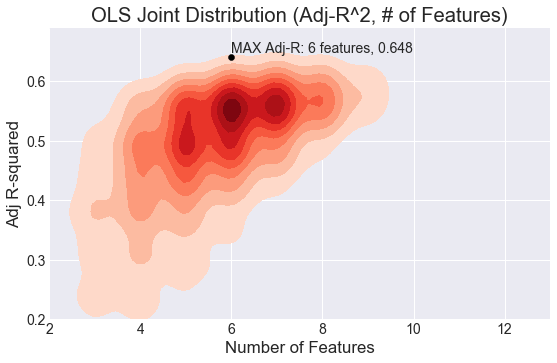

In [57]:
fig, ax = plt.subplots(figsize=(8,5))
plt.style.use('fivethirtyeight')
sns.set_style('darkgrid')
sns.kdeplot([len(x) for x in variables],adj_r, cmap='Reds', shade=True, shade_lowest=False)
plt.title('OLS Joint Distribution (Adj-R^2, # of Features)')
plt.scatter(6, 0.64, c='black')
plt.xlabel('Number of Features')
plt.ylabel('Adj R-squared')
plt.annotate(s='MAX Adj-R: 6 features, 0.648',xy=(6, 0.648))
plt.ylim((0.2,0.69))
plt.xlim((2, 13))

In [60]:
df = X.copy()
df = df[['Num Wiki References', 'profile_dates_mean', 'profile_dates_std', 
         'presidency_length', 'more_than_10000_deaths','sqrt_trend']]
df = sm.add_constant(df)
ols = sm.OLS(y, df).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:          Words on Page   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     12.34
Date:                Fri, 11 May 2018   Prob (F-statistic):           4.59e-07
Time:                        10:49:35   Log-Likelihood:                -406.75
No. Observations:                  38   AIC:                             827.5
Df Residuals:                      31   BIC:                             839.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   7.94

In [61]:
#same thing without wiki references
X = X.drop(['Num Wiki References'], axis=1)
variables = []
adj_r = []
for i in tqdm(range(1, 11)):
    combos = list(combinations(list(X.columns), i))
    for co in combos:
        variables.append(co)
        df = X.copy()
        df = df[list(co)]
        df = sm.add_constant(df)
        ols = sm.OLS(y, df).fit()
        adj_r.append(ols.rsquared_adj)

print(adj_r[adj_r.index(max(adj_r))])
print(variables[adj_r.index(max(adj_r))])

100%|██████████| 10/10 [00:02<00:00,  3.50it/s]

0.626071560028951
('birth_year', 'profile_dates_mean', 'profile_dates_std', 'more_than_10000_deaths', 'sqrt_trend')


In [67]:
df = X.copy()
df = df[['birth_year', 'profile_dates_mean', 'profile_dates_std', 
         'more_than_10000_deaths', 'sqrt_trend']]
df = sm.add_constant(df)
ols = sm.OLS(y, df).fit()
print('R-squared w/o wiki references', ols.rsquared)

R-squared w/o wiki references 0.676602430295309


In [68]:
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:          Words on Page   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     13.39
Date:                Fri, 11 May 2018   Prob (F-statistic):           4.48e-07
Time:                        10:53:21   Log-Likelihood:                -408.49
No. Observations:                  38   AIC:                             829.0
Df Residuals:                      32   BIC:                             838.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   7.94

In [69]:
#saving to csv for plotly images

#NOTE: this was for previous models sans google trends

# new_df['wo_adj_r'] = adj_r + [np.nan for i in range(2048)] #
# new_df['wo_variables'] = variables + [np.nan for i in range(2048)]
# new_df['wo_length'] = [len(i) for i in variables] + [np.nan for i in range(2048)]
# new_df.to_csv('./images/models_images.csv')

ValueError: Length of values does not match length of index